# Clase 3 – Visión Artificial con Redes Neuronales (CNN)
**Sesión presencial (BCN Chile) – Notebook de demo**

## Objetivos
Al finalizar esta demo deberías poder:
- Entender una imagen como un **tensor** (matriz de números) y por qué normalizamos.
- Explicar por qué una **CNN** es más adecuada que un **MLP** para imágenes (localidad + pesos compartidos).
- Entrenar una CNN simple **end-to-end** para **clasificación**.
- Evaluar con **accuracy**, **matriz de confusión** y análisis de errores.
- Mostrar evidencias de “cómo mira” la CNN: **feature maps** y **saliency** (interpretabilidad ligera).
- Conectar el pipeline con casos BCN: **clasificar páginas** (tabla/gráfico/texto/portada) y preparar el salto conceptual a detección/OCR.

> **Frase guía:** *Pasamos de pixeles a decisiones, aprendiendo representaciones.*

    ! pip install torch torchvision torchaudio


## Nota para la sala (modo demo)
Este notebook está diseñado para correr **sin internet** y en **CPU**.
- Usaremos el dataset `digits` (dígitos manuscritos 8×8) porque entrena rápido.
- El pipeline es idéntico al de documentos reales; lo que cambia es el dataset.

In [30]:
# 0) Setup
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Modo sala (rápido)
FAST_MODE = False
EPOCHS = 3 if FAST_MODE else 15
BATCH_SIZE = 64
LR = 1e-3

Device: cpu


# 1) ¿Qué es una imagen para un computador?
Una imagen es una **matriz/tensor de números**:
- Escala de grises: `H × W`
- Color (RGB): `H × W × C` (C=3)

En este demo, cada imagen es 8×8 en escala de grises.

In [31]:
# 1.1 Cargar dataset (digits) y explorar
digits = load_digits()
X = digits.images.astype(np.float32)         # (N, 8, 8)
y = digits.target.astype(np.int64)           # (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Clases:", np.unique(y))

X shape: (1797, 8, 8)
y shape: (1797,)
Clases: [0 1 2 3 4 5 6 7 8 9]


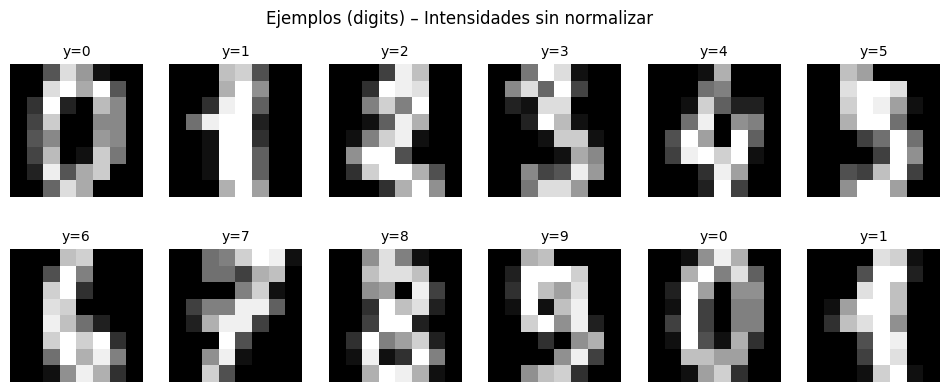

In [32]:
# 1.2 Visualizar ejemplos (antes de normalizar)
def show_grid(images, labels=None, n=12, title=None):
    n = min(n, len(images))
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(12, 2.2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
        if labels is not None:
            plt.title(f"y={labels[i]}", fontsize=10)
    if title:
        plt.suptitle(title)
    plt.show()

show_grid(X, y, n=12, title="Ejemplos (digits) – Intensidades sin normalizar")

## 1.3 Normalización (por qué)
Los pixeles originales del dataset `digits` están típicamente en rango **0–16**.  
Normalizamos a **0–1** para facilitar el entrenamiento: gradientes más estables, convergencia más rápida.

Min/Max antes: 0.0 16.0
Min/Max después: 0.0 1.0


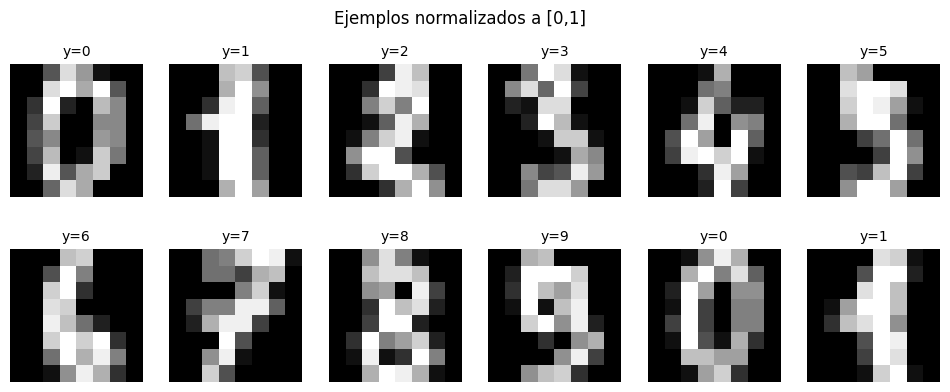

In [33]:
# Normalización a [0,1]
Xn = X / 16.0

print("Min/Max antes:", X.min(), X.max())
print("Min/Max después:", Xn.min(), Xn.max())

show_grid(Xn, y, n=12, title="Ejemplos normalizados a [0,1]")

# 2) Preparación de datos para una CNN
En PyTorch, el formato estándar es:
- **(N, C, H, W)**  → *channels first*

Aquí C=1 (grises).

In [34]:
# Agregar canal: (N, 1, 8, 8)
Xn = Xn[:, None, :, :]

# Split train/val/test (estratificado)
X_train, X_temp, y_train, y_temp = train_test_split(
    Xn, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train: (1257, 1, 8, 8) Val: (270, 1, 8, 8) Test: (270, 1, 8, 8)


# 3) CNN: Intuición + arquitectura mínima
## Qué hace una CNN (sin matemáticas)
- Usa **filtros** (kernels) que recorren la imagen y detectan patrones locales.
- Produce **feature maps** (mapas de activación).
- Combina patrones en capas sucesivas: bordes → trazos → formas → clase.

Usaremos una CNN pequeña (rápida en CPU), suficiente para mostrar el pipeline end-to-end.

In [35]:
# 3.1 Definir modelo CNN pequeño
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # 8x8 -> (conv3) -> 6x6
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.relu  = nn.ReLU()
        # 6x6 -> pool2 -> 3x3
        self.pool  = nn.MaxPool2d(2)
        # 3x3 -> (conv2) -> 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        # 32*2*2 -> 64 -> 10
        self.fc1   = nn.Linear(32*2*2, 64)
        self.fc2   = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # logits (sin softmax)
        return x

model = SmallCNN().to(DEVICE)
print(model)

SmallCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


## Nota conceptual importante: logits vs probabilidades
La red entrega **logits** (scores) por clase.  
- Durante entrenamiento usamos **CrossEntropyLoss**, que internamente aplica softmax + entropía cruzada.
- Para predecir clase: tomamos el **argmax** del score.

In [36]:
# 3.2 Entrenamiento: loss + optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def evaluate(loader):
    model.eval()
    all_true, all_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            pred = logits.argmax(dim=1)
            all_true.append(yb.cpu().numpy())
            all_pred.append(pred.cpu().numpy())
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_true, all_pred)
    return avg_loss, acc, all_true, all_pred

In [37]:
# 3.3 Loop de entrenamiento (modo sala)
best_val_acc = -1.0
best_state = None

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    all_true, all_pred = [], []

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(dim=1)
        all_true.append(yb.cpu().numpy())
        all_pred.append(pred.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(np.concatenate(all_true), np.concatenate(all_pred))

    val_loss, val_acc, _, _ = evaluate(val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

# Restaurar mejor modelo
model.load_state_dict(best_state)
print("Mejor val_acc:", best_val_acc)

Epoch 01/15 | train_loss=2.2830 train_acc=0.2251 | val_loss=2.2489 val_acc=0.4185
Epoch 02/15 | train_loss=2.1929 train_acc=0.5052 | val_loss=2.1092 val_acc=0.6000
Epoch 03/15 | train_loss=1.9521 train_acc=0.6014 | val_loss=1.7501 val_acc=0.5815
Epoch 04/15 | train_loss=1.5155 train_acc=0.6062 | val_loss=1.2964 val_acc=0.7185
Epoch 05/15 | train_loss=1.0977 train_acc=0.7653 | val_loss=0.9468 val_acc=0.7778
Epoch 06/15 | train_loss=0.7923 train_acc=0.8051 | val_loss=0.7080 val_acc=0.8185
Epoch 07/15 | train_loss=0.6062 train_acc=0.8298 | val_loss=0.5955 val_acc=0.8407
Epoch 08/15 | train_loss=0.5023 train_acc=0.8624 | val_loss=0.4960 val_acc=0.8667
Epoch 09/15 | train_loss=0.4353 train_acc=0.8743 | val_loss=0.4294 val_acc=0.8778
Epoch 10/15 | train_loss=0.3814 train_acc=0.8950 | val_loss=0.3950 val_acc=0.8815
Epoch 11/15 | train_loss=0.3328 train_acc=0.9069 | val_loss=0.3545 val_acc=0.9000
Epoch 12/15 | train_loss=0.3065 train_acc=0.9157 | val_loss=0.3340 val_acc=0.9148
Epoch 13/15 | tr

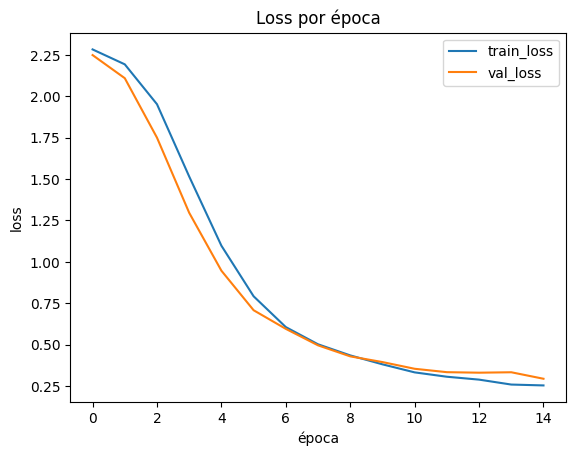

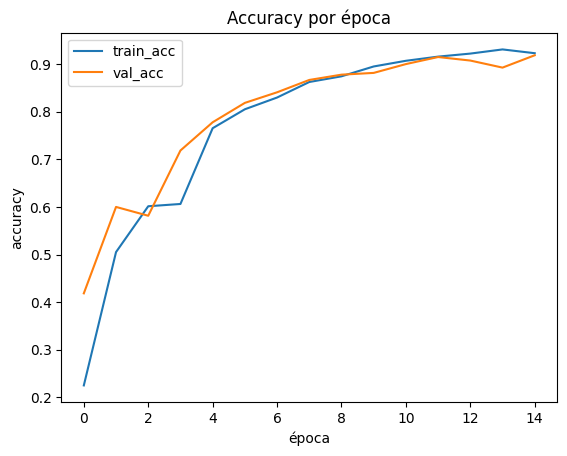

In [38]:
# 3.4 Curvas de aprendizaje (simple)
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss por época")
plt.xlabel("época")
plt.ylabel("loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Accuracy por época")
plt.xlabel("época")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# 4) Evaluación final + matriz de confusión + análisis de errores
Este bloque es clave para sonar “experto”:
- No basta con accuracy: hay que ver **en qué se equivoca** el modelo.
- La matriz de confusión muestra confusiones sistemáticas.

Test loss=0.2549 | Test acc=0.9074


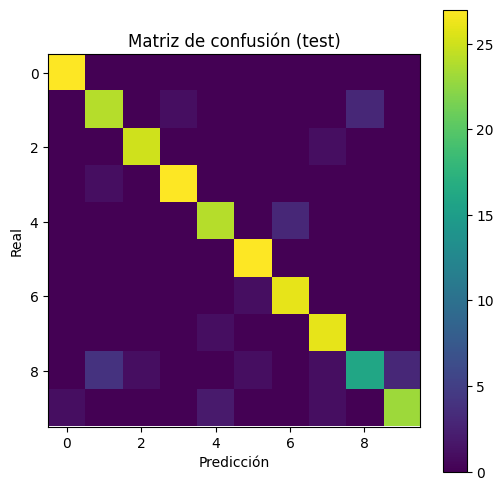

In [39]:
test_loss, test_acc, y_true, y_pred = evaluate(test_loader)
print(f"Test loss={test_loss:.4f} | Test acc={test_acc:.4f}")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Matriz de confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()

Cantidad de errores: 25


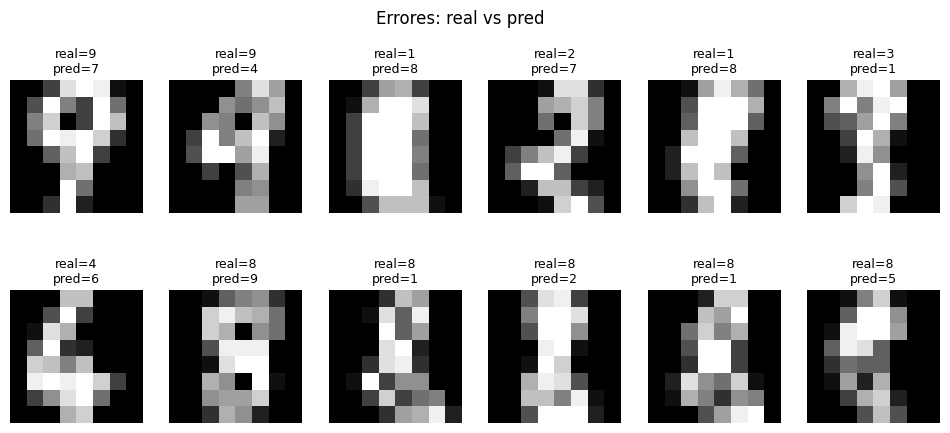

In [40]:
# 4.1 Mostrar ejemplos de errores (si existen)
errors = np.where(y_true != y_pred)[0]
print("Cantidad de errores:", len(errors))

if len(errors) > 0:
    idx = errors[:12]
    imgs = X_test[idx, 0]  # canal 0
    labs = [(y_true[i], y_pred[i]) for i in idx]
    plt.figure(figsize=(12, 5))
    for j in range(len(idx)):
        plt.subplot(2, 6, j+1)
        plt.imshow(imgs[j], cmap="gray")
        plt.axis("off")
        plt.title(f"real={labs[j][0]}\npred={labs[j][1]}", fontsize=9)
    plt.suptitle("Errores: real vs pred")
    plt.show()

# 5) ¿Cómo “mira” la CNN? (interpretabilidad ligera)
Aquí NO prometemos causalidad. Mostramos evidencia:
- **Feature maps** (qué patrones activan en una capa)
- **Saliency** (qué pixeles influyeron más)

Esto es útil para:
- Explicar el “proceso mental” de la red (de forma honesta).
- Diagnosticar si el modelo se apoya en artefactos.

## 5.1 Feature maps (primera convolución)
La primera capa suele aprender detectores simples (trazos/bordes).

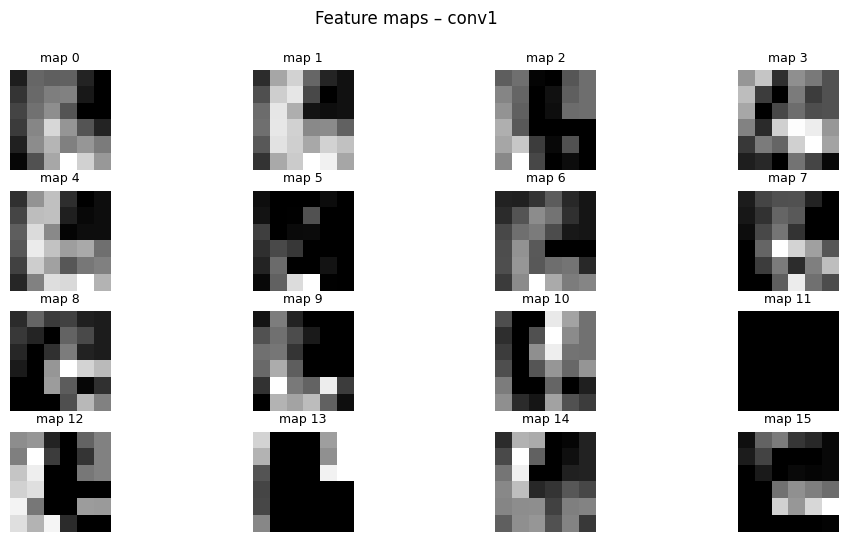

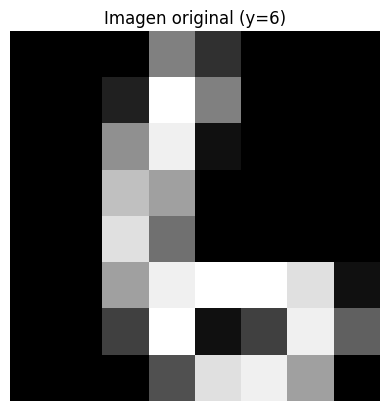

In [50]:
# Elegir una imagen (del test)
i = 0
img = torch.tensor(X_test[i:i+1]).to(DEVICE)  # (1,1,8,8)

model.eval()
with torch.no_grad():
    fmap = model.relu(model.conv1(img)).cpu().numpy()[0]  # (16, 6, 6)

plt.figure(figsize=(12, 6))
for k in range(16):
    plt.subplot(4, 4, k+1)
    plt.imshow(fmap[k], cmap="gray")
    plt.axis("off")
    plt.title(f"map {k}", fontsize=9)
plt.suptitle("Feature maps – conv1 ")
plt.show()

plt.figure()
plt.imshow(X_test[i,0], cmap="gray")
plt.title(f"Imagen original (y={y_test[i]})")
plt.axis("off")
plt.show()

## 5.2 Saliency map (gradiente sobre el input)
Idea: medir qué tan sensible es el score de una clase respecto a cada píxel.
- Si al cambiar un píxel, cambia mucho el score → ese píxel influyó más.
- No es una “explicación completa”, pero es un **buen control de calidad**.

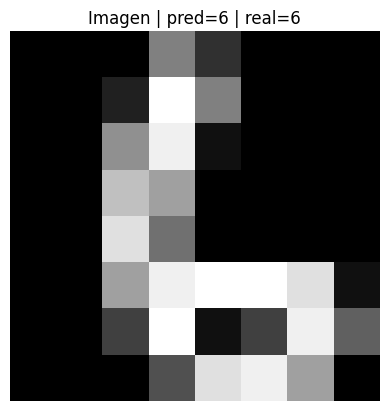

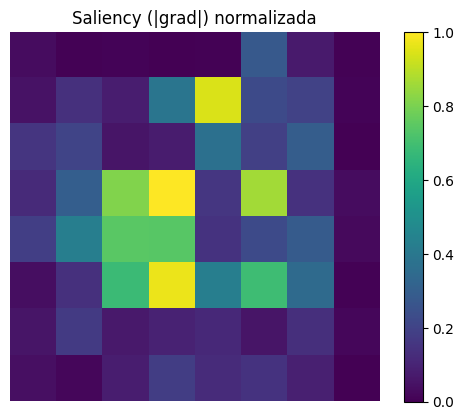

In [42]:
# Saliency: gradiente de la clase predicha con respecto al input
model.eval()

img = torch.tensor(X_test[i:i+1], requires_grad=True).to(DEVICE)
logits = model(img)
pred_class = logits.argmax(dim=1).item()

score = logits[0, pred_class]
score.backward()

sal = img.grad.detach().cpu().numpy()[0, 0]      # (8,8)
sal = np.abs(sal)
sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

plt.figure()
plt.imshow(X_test[i,0], cmap="gray")
plt.title(f"Imagen | pred={pred_class} | real={y_test[i]}")
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(sal)
plt.title("Saliency (|grad|) normalizada")
plt.axis("off")
plt.colorbar()
plt.show()

# 6) Conexión BCN: del demo a documentos reales
## Misma receta, distinto dataset
Para clasificar páginas de documentos (ej. **tabla / gráfico / texto / portada**):
1) Recolectar imágenes de páginas (JPG/PNG) o convertir PDF a imágenes.
2) Etiquetar (rubrica simple y consistente).
3) Entrenar la CNN (transfer learning si el dataset es pequeño).
4) Evaluar + analizar errores.
5) Integrar al flujo: enrutamiento de páginas, priorización, QA de OCR.

## Clasificación vs detección vs segmentación (resumen)
- **Clasificación:** etiqueta para la imagen completa (lo que hicimos hoy).
- **Detección:** cajas + clases (qué y dónde).
- **Segmentación:** máscara por píxel.

> Siguiente salto natural: detección de tablas / sellos / firmas en páginas.

# 7) (Opcional) Plantilla para usar imágenes propias desde carpetas
Estructura sugerida:

```
data/pages/
  tabla/
  grafico/
  texto/
  portada/
```

Cada subcarpeta contiene imágenes. El pipeline es igual: cargar → split → dataloader → CNN.
Esta sección está “lista” para activarse cuando dispongas de datos etiquetados.

In [43]:
# (Opcional) Dataset local desde carpetas
# Nota: esta celda no se ejecuta si no existe la ruta.
# Está pensada para cuando tengas imágenes reales etiquetadas.

import pathlib
from PIL import Image

DATA_DIR = pathlib.Path("data/pages")  # ajusta ruta si corresponde

def load_folder_dataset(root: pathlib.Path, image_size=(128, 128)):
    classes = sorted([p.name for p in root.iterdir() if p.is_dir()])
    class_to_idx = {c:i for i,c in enumerate(classes)}
    images, labels = [], []

    for c in classes:
        for fp in (root / c).glob("*"):
            if fp.suffix.lower() not in [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]:
                continue
            img = Image.open(fp).convert("RGB").resize(image_size)
            arr = np.asarray(img).astype(np.float32) / 255.0  # HWC
            images.append(arr)
            labels.append(class_to_idx[c])

    if len(images) == 0:
        raise RuntimeError(f"No encontré imágenes en {root}.")

    X = np.stack(images, axis=0)                # (N,H,W,C)
    y = np.array(labels, dtype=np.int64)        # (N,)
    return X, y, classes

if DATA_DIR.exists():
    X_img, y_img, classes = load_folder_dataset(DATA_DIR)
    print("Dataset local:", X_img.shape, "Clases:", classes)
else:
    print(f"DATA_DIR no existe aún: {DATA_DIR} (ok para demo)")

DATA_DIR no existe aún: data\pages (ok para demo)


# 8) Guardar / cargar modelo (Plan B para sala)
Si el entrenamiento se demora o el computador es lento, puedes:
- entrenar antes y guardar pesos
- en clase cargar el modelo y mostrar inferencia + interpretabilidad

In [44]:
# Guardar pesos (descomenta si quieres guardar)
# torch.save(model.state_dict(), "smallcnn_digits.pt")
# print("Modelo guardado en smallcnn_digits.pt")

# Cargar pesos (ejemplo)
# model2 = SmallCNN().to(DEVICE)
# model2.load_state_dict(torch.load("smallcnn_digits.pt", map_location=DEVICE))
# model2.eval()
# print("Modelo cargado")